<a href="https://colab.research.google.com/github/skytmddus27/first/blob/master/kcBertFineTuningHuggingface.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Kcbert finetuning
기본 kcbert를 허깅페이스에서 불러와서 네이버영화데이터로 파인튜닝을 진행한다. <p>
다만 모델 구조를 새롭게 선언하지 않고 허깅페이스의 기본 모듈들과 트레이너를 사용해 학습 후에 모델의 체크포인트를 불러오는 가장 기본적인 방식을 활용했다. <p>
1. model freeze 선언 : classifier만을 학습시킨다.
2. 허깅페이스 Trainer Argument 활용
3. 허깅페이스에서 early stopping 추가

### 필요한 모듈 불러오기

In [1]:
import torch

print(torch.__version__)

# 파이토치 다운그레이드
# conda install pytorch == 1.5.1 torchvision == 0.6.1 -c pytorch

1.10.0+cu111


In [2]:
!pip list | grep transformers
!pip list | grep torch
!pip list | grep numpy

torch                         1.10.0+cu111
torchaudio                    0.10.0+cu111
torchsummary                  1.5.1
torchtext                     0.11.0
torchvision                   0.11.1+cu111
numpy                         1.21.5


In [4]:
import torch 
from torch import nn, Tensor
from torch.optim import Optimizer
from torch.utils.data import DataLoader, RandomSampler, DistributedSampler, random_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn import CrossEntropyLoss
# from pytorch_lightning.core.lightning import LightningModule
# from pytorch_lightning import LightningModule, Trainer, seed_everything
# from pytorch_lightning.metrics.functional import accuracy, precision, recall
# from transformers.models.bert.modeling_bert import BertModel
from keras.preprocessing.sequence import pad_sequences

import random
import numpy as np

import time
import datetime
import pandas as pd
import os
from tqdm import tqdm

# ImportError : cannot import name 'SAVE_STATE_WARNING'
# SAVE_STATE_WARNING from PyTorch. only exists in 1.5.0
# downgrade pytorch version to 1.5.0  

In [5]:
!pip install emoji
!pip install soynlp

     |████████████████████████████████| 175 kB 5.3 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=c7e167abbbecaf43d05216cdb5d63bbf94471878fce4afae9a55137cb7319c5c
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built emoji
     |████████████████████████████████| 416 kB 5.0 MB/s 


In [37]:
from torch.optim.lr_scheduler import ExponentialLR
import re
import emoji
from soynlp.normalizer import repeat_normalize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support
from pprint import pprint

In [7]:
if torch.cuda.is_available():

    # 파이토치에 GPU 할당
    device = torch.device("cuda")

    print('There are %d GPU(s) avilable.' %torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead')
    device = torch.device('cpu')

There are 1 GPU(s) avilable.
We will use the GPU: Tesla K80


### 모델과 토크나이저

In [10]:
!pip install transformers

     |████████████████████████████████| 3.8 MB 5.2 MB/s 
     |████████████████████████████████| 6.5 MB 31.6 MB/s 
     |████████████████████████████████| 67 kB 4.4 MB/s 
     |████████████████████████████████| 895 kB 40.5 MB/s 
     |████████████████████████████████| 596 kB 45.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [11]:
from transformers import AdamW, BertForSequenceClassification, BertConfig, AutoTokenizer, BertTokenizer

In [12]:
# 토크나이저: kcbert

model_name = 'beomi/kcbert-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained('beomi/kcbert-base')

Downloading:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/619 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/244k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

Some weights of the model checkpoint at beomi/kcbert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initiali

## 데이터 로드 후 콘텐츠만 추출

In [19]:
alt = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/3rd project/data/kor/alt.csv")
btc = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/3rd project/data/kor/btc.csv")
eth = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/3rd project/data/kor/eth.csv")
xrp = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/3rd project/data/kor/xrp.csv")

df = pd.concat([alt, btc, eth, xrp])
df

,title,body,date_time,labeling,Unnamed: 4
0,공식 어플 설치하고 코인정보를 받아보세요!,"5월 31일, 코인판 공식 어플이 드디어 출시되었습니다.\n이제, 코인판?어플을 통...",2016.05.31 / 21:19,3,NaN
1,코박토큰 어제 12시에 존나 날라가더만,NaN,2021.10.30 / 17:17,0,NaN
2,시총 144 억 코박이 하고 놀자,NaN,2021.10.30 / 15:27,0,NaN
3,쿼크가면 코박간다,NaN,2021.10.30 / 13:05,0,NaN
4,불나방 안했으면 좋겠다.,NaN,2021.10.30 / 12:54,0,NaN
...,...,...,...,...,...
3995,리 리리리리,NaN,2021.05.23 / 17:53,2,NaN
3996,리플 차트그리는 80렙 고인물 어디갔냐,NaN,2021.05.23 / 17:52,2,NaN
3997,너무 정직하게 떨어지는게 참 모를일이네요..,NaN,2021.05.23 / 17:51,2,NaN
3998,동전주되기전이네ㅅㅂ,NaN,2021.05.23 / 17:48,2,NaN


In [21]:
df.drop(['Unnamed: 4'], axis = 1, inplace = True)
df = df[df['labeling'] != 3]
df = df.replace(np.nan, "")
df['text'] = df['title'] + " " + df['body']
df

,title,body,date_time,labeling,text
1,코박토큰 어제 12시에 존나 날라가더만,,2021.10.30 / 17:17,0,코박토큰 어제 12시에 존나 날라가더만
2,시총 144 억 코박이 하고 놀자,,2021.10.30 / 15:27,0,시총 144 억 코박이 하고 놀자
3,쿼크가면 코박간다,,2021.10.30 / 13:05,0,쿼크가면 코박간다
4,불나방 안했으면 좋겠다.,,2021.10.30 / 12:54,0,불나방 안했으면 좋겠다.
5,코박 바닥찍고 반등중!! 바닥에서 잡아놔라!!,코박 바닥찍고 반등중!! 바닥에서 잡아놔라!!,2021.10.30 / 11:43,0,코박 바닥찍고 반등중!! 바닥에서 잡아놔라!! 코박 바닥찍고 반등중!! 바닥에서 잡...
...,...,...,...,...,...
3995,리 리리리리,,2021.05.23 / 17:53,2,리 리리리리
3996,리플 차트그리는 80렙 고인물 어디갔냐,,2021.05.23 / 17:52,2,리플 차트그리는 80렙 고인물 어디갔냐
3997,너무 정직하게 떨어지는게 참 모를일이네요..,,2021.05.23 / 17:51,2,너무 정직하게 떨어지는게 참 모를일이네요..
3998,동전주되기전이네ㅅㅂ,,2021.05.23 / 17:48,2,동전주되기전이네ㅅㅂ


In [22]:
train_set = df[0:10000]
valid_set = df[10000:11000]
test_set = df[11000:]

### 데이터 전처리

In [30]:
# 데이터 전처리 함수를 선언해준다.
class TheDataset(torch.utils.data.Dataset):

    def __init__(self, text, label, tokenizer):
        self.text = text
        self.label = label
        self.tokenizer = tokenizer
        self.max_len = tokenizer.model_max_length

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        label = self.label[index]

        encoded_review = self.tokenizer.encode_plus(
            text,
            add_special_tokens = True,
            max_length = self.max_len,
            return_token_type_ids = False,
            return_attention_mask = True,
            return_tensors = 'pt',
            padding = 'max_length',
            truncation = True
        )

        return {
            'input_ids': encoded_review['input_ids'][0],
            'attention_mask': encoded_review['attention_mask'][0],
            'labels': torch.tensor(label, dtype = torch.long)
        }

In [33]:
# text를 tolist를 활용하여 리스트 변환, 라벨 또한 리스트로 변환해준다.
# dataloader에 리스트로 변환된 값을 넣어 토치텐서로 변환해준다.
# batchsize는 32일때 out of memory error가 나기에 16으로 고정해주었다.
train_set_dataset = TheDataset(
    text = train_set.text.tolist(),
    label = train_set.labeling.tolist(),
    tokenizer = tokenizer,
)

valid_set_dataset = TheDataset(
    text = valid_set.text.tolist(),
    label = valid_set.labeling.tolist(),
    tokenizer = tokenizer
)

# Create DataLoader for train/validation sets
train_set_dataloader = torch.utils.data.DataLoader(
    train_set_dataset,
    batch_size = 16,
    num_workers = 4
)

valid_set_dataloader = torch.utils.data.DataLoader(
    valid_set_dataset,
    batch_size = 16,
    num_workers = 4
)

# Get one batch as example
train_data = next(iter(train_set_dataloader))
valid_data = next(iter(valid_set_dataloader))

# Print the output sizes
print(train_data['input_ids'].size(), valid_data['input_ids'].size())

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([16, 300]) torch.Size([16, 300])


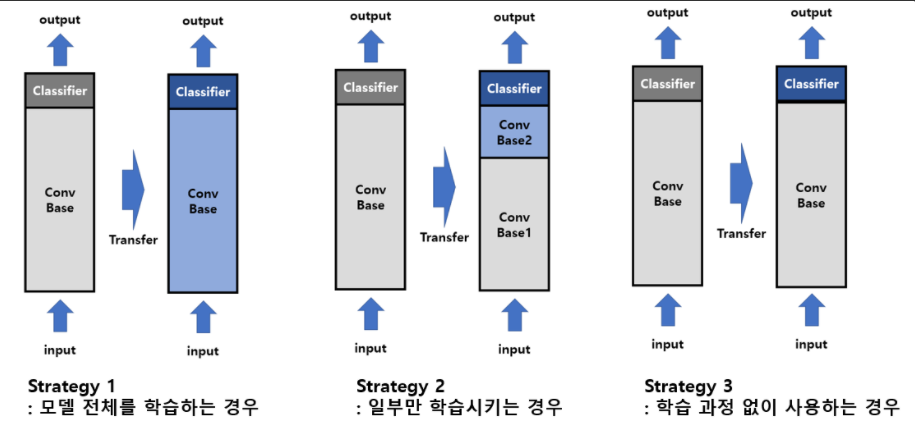

### model freeze
모델의 classifier layer를 제외한 레이어를 동결시키는 코드

In [34]:
for name, param in model.bert.named_parameters():
    param.requires_grad = False

### model freeze 2
모델의 pooler와 bert23번째 레이어 그리고 classifier를 제외한 모든 레이어를 동결하는 코드. <p>
어느 레이어를 동결시키느냐에 따라 결과가 다르니 실험적으로 사용해볼 것

In [36]:
for name, param in model.bert.named_parameters():
    if (not name.startswith('pooler')) and "layer.23" not in name:
        param.requires_grad = False

### compute_metrics 선언

In [38]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, averages = 'binary')
    acc = accuracy_score(labels, preds)
    return{
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

### hugging face의 Trainer와 TrainerArguments를 사용하여 모델을 정의해준다.
training_args에 선언된 argument들이 모델에 들어가게 된다. <p>
output_dir = 모델이 저장될 디렉토리 <p>
epochs : epoch를 할당하는 변수 <p>
evaluation_strategy와 #load_best_model_at_end를 trainer argument에 포함하면 early stopping을 사용할 수 있다. <p>
evaluation_strategy 'no', 'steps', 'epoch' 세가지 값을 가진다. <p>
'no': 트레이닝 동안 evaluation을 진행하지 않는다. <p>
'steps': evaluation이 매 eval_steps마다 진행된다. <p>
'epoch': evaluation이 매 epoch가 끝날때마다 진행된다. <p>

또한 learning_rate와 epsilon도 Training Arguments의 파라미터에서 설정할 수 있다. 그 외에도 다양한 파라미터들이 있으니 직접 설명을 살펴보고 진행하는 것이 좋다. <p>

Trainer에 포함된 모듈들은 https://huggingface.co/transformers/main_classes/trainer.html 에서 확인할 수 있다. <p>
Argument에 포함된 모듈들은 https://huggingface.co/transformers/main_classes/trainer.html#transformers.TrainingArguments 에서 확인 가능하다.

### Early stopping 추가하는 법
1. from transformer import EarlyStoppingCallback
2. callbacks 선언
3. Trainer에 callbacks 추가
4. TrainingArguments에 load_best_model_at_end = True로 지정해준다.

In [40]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir = './sentiment-anlaysis',
    num_train_epochs = 1,
    per_device_train_batch_size = 32,
    per_device_eval_batch_size = 32,
    warmup_steps = 500,
    weight_decay = 0.01,
    evaluation_strategy = 'steps'
)

In [41]:
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = train_set_dataset,
    eval_dataset = valid_set_dataset,
    compute_metrics = compute_metrics
)

In [42]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 10000
  Num Epochs = 1
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 313


RuntimeError: ignored